<h2>Baltic Dry Index Prediction based on EEMD-LSTM</h2>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time
import os
import concurrent.futures
import scipy.signal as signal
from scipy.stats import norm
from scipy import interpolate
from datetime import datetime
from bs4 import BeautifulSoup
from urllib.request import urlopen
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1, l2

<h3>1.1 資料收集</h3>

    使用爬蟲獲取鉅亨網2000年至今波羅的海運價指數。

In [2]:
def scrapy(date):
    baseurl = 'https://www.cnyes.com/futures/History.aspx?mydate='
    his = date+'&code=BDI'
    url = baseurl + his
    try:
        respone = urlopen(url)
    except:
        pass
    else:
        html = urlopen(url).read().decode('utf-8')
        soup = BeautifulSoup(html)
        td = soup.find_all('td')
        if len(td)<21:
            return date
        else:
            return f'{date},{td[19].get_text()}'
        
def dateindex(start, end):
    return [datetime.strftime(i,'%Y%m%d') for i in list(pd.date_range(start=start, end=end))]


<h3>1.2 缺值</h3>

    為確保每筆資料間隔時間固定，對缺值進行差值。

In [3]:
df = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date'])
df.head()

,bdi
date,
2000-01-01,1319.0
2000-01-02,NaN
2000-01-03,NaN
2000-01-04,1320.0
2000-01-05,1329.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 2000-01-01 to 2020-10-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bdi     5182 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


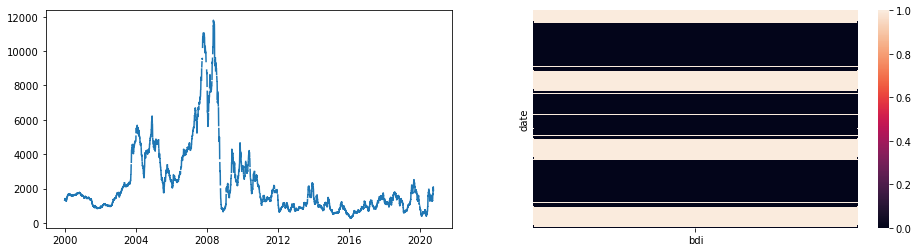

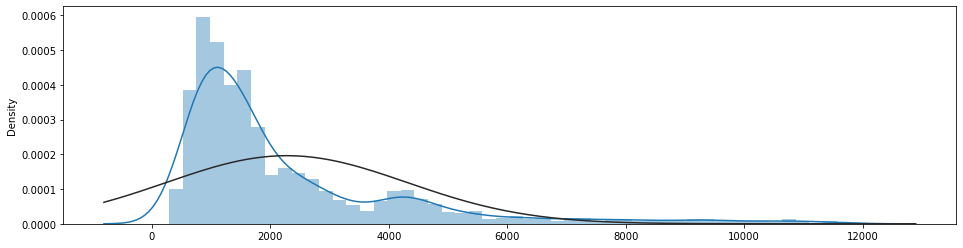

In [5]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(df)
plt.subplot(1,2,2)
sb.heatmap(df.isnull(), yticklabels=False, cbar=True)
plt.figure(figsize=(16, 4))
sb.distplot(df, kde=True, fit=norm)
plt.show()

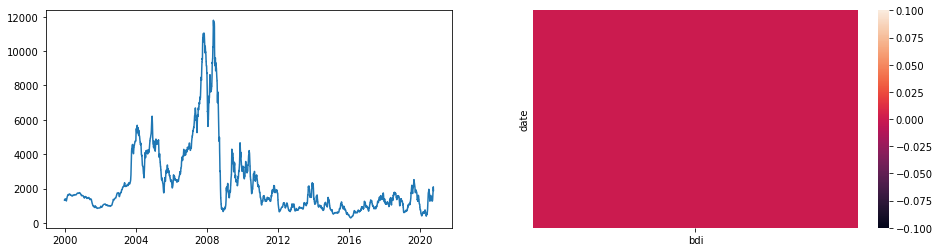

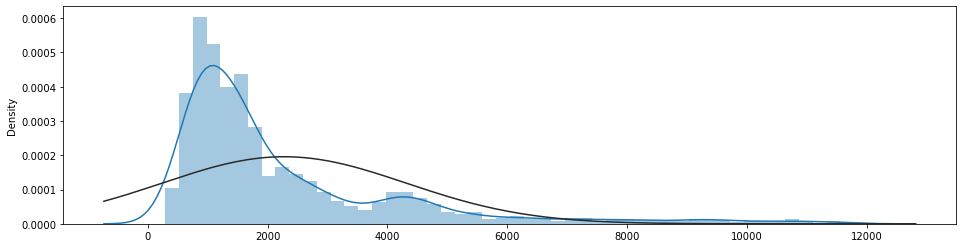

In [6]:
df = df.fillna(method='ffill')
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(df)
plt.subplot(1,2,2)
sb.heatmap(df.isnull(), yticklabels=False, cbar=True)
plt.figure(figsize=(16, 4))
sb.distplot(df, kde=True, fit=norm)
plt.show()

In [7]:
data = df['bdi'].values
d = {'Actual': data}

<h3>2.1 總體經驗模態分解</h3>

    經驗模態分解:
    步驟一、判斷資料是否符合單調函數定義。
            單調函數定義：無區域極值。
    步驟二、判斷資料是否符合本徵模函數定義。
            本徵模函數定義：零均值、區域極值總數與過零點總數相差小於等於1。
    步驟三、利用資料的區域最大值與區域最小值，建立上包絡線與下包絡線。
    步驟四、資料減去上下包絡線的平均。
    步驟五、判斷資料是否符合本徵模函數定義。如未符合重複步驟三四。符合則產生第一組模態。
    步驟六、資料減去第一組模態，判斷是否符合單調函數，如未符合重複步驟三四五。
    步驟七、資料完成分解為多組本徵模函數，與一組單調函數。
    
    弊病：
    邊界效應、位於邊界的包絡線因差值困難導致失真。
    模態數量不一致、資料長度的增減會導致模態的數量產生變化。
    混模、小範圍噪音會影響模態分解的品質，並持續傳播影響後面多組模態。
    
    解決方法：
    鏡像擴充
    總體經驗模態分解
    

In [8]:
def ismonotonic(x):
    max_peaks = signal.argrelextrema(x, np.greater)[0]
    min_peaks = signal.argrelextrema(x, np.less)[0]
    all_num = len(max_peaks) + len(min_peaks)
    if all_num > 0:
        return False
    else:
        return True

def isimf(x):
    N = np.size(x)
    pass_zero = np.sum(x[0:N - 2] * x[1:N - 1] < 0)
    peaks_num = np.size(findpeaks(x)) + np.size(findpeaks(-x))
    if abs(pass_zero - peaks_num) > 1:
        return False
    else:
        return True

def findpeaks(x):
    return signal.argrelextrema(x, np.greater)[0]

def getspline(x):
    N = np.size(x)
    peaks = findpeaks(x)
    if len(peaks) <= 3:
        if len(peaks) < 2:
            peaks = np.concatenate(([0], peaks))
            peaks = np.concatenate((peaks, [N - 1]))
        t = interpolate.splrep(peaks, y=x[peaks], w=None, xb=None, xe=None, k=len(peaks) - 1)
        return interpolate.splev(np.arange(N), t)
    t = interpolate.splrep(peaks, y=x[peaks])
    return interpolate.splev(np.arange(N), t)

def noise(x, amp):
    return x + (np.random.randn(len(x)) * amp)

def mirror(x):
    i = np.arange(len(x) - 2, 0, -1)
    reverse_x = x[i]
    reverse_x = list(reverse_x)
    x = list(x)
    return np.array(reverse_x + x + reverse_x)

def emd(x):
    imf = []
    while not ismonotonic(x):
        x1 = x
        sd = np.inf
        while sd > 0.2 or (not isimf(x1)):
            x1 = mirror(x1)
            s1 = getspline(x1)
            s2 = -getspline(-1 * x1)
            x2 = x1 - (s1 + s2) / 2
            x1 = x1[len(x) - 2:-len(x) + 2]
            x2 = x2[len(x) - 2:-len(x) + 2]
            sd = np.sum((x1 - x2) ** 2) / np.sum(x1 ** 2)
            x1 = x2
        imf.append(x1)
        x = x - x1
    imf.append(x)
    return imf

def eemd(x, amp, times, n_modes):
    x = x.reshape(-1)
    imf, n = 0, 0
    for _ in range(times):
        modes = emd(noise(x, amp))
        if len(modes) == n_modes:
            imf += np.array(modes)
            n += 1
    for i in range(len(imf)):
        imf[i] = imf[i] / n
    return imf

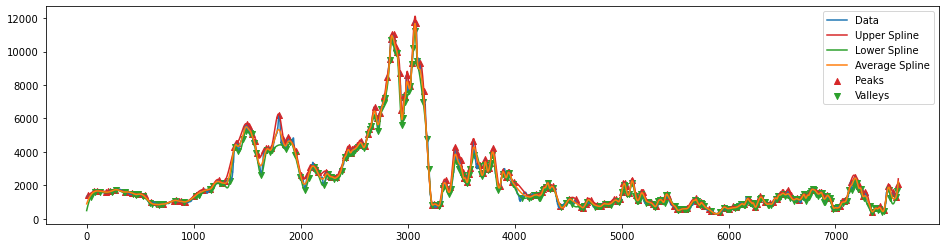

In [9]:
peak = findpeaks(data)
valley = findpeaks(-data)
plt.figure(figsize=(16, 4))
plt.plot(data, c='tab:blue', label='Data')
plt.scatter(peak, data[peak], c='tab:red', marker='^', label='Peaks')
plt.scatter(valley, data[valley], c='tab:green', marker='v', label='Valleys')
plt.plot(getspline(data), c='tab:red', label='Upper Spline')
plt.plot(-getspline(-data), c='tab:green', label='Lower Spline')
plt.plot((getspline(data)-getspline(-data)) / 2, c='tab:orange', label='Average Spline')
plt.legend()
plt.show()

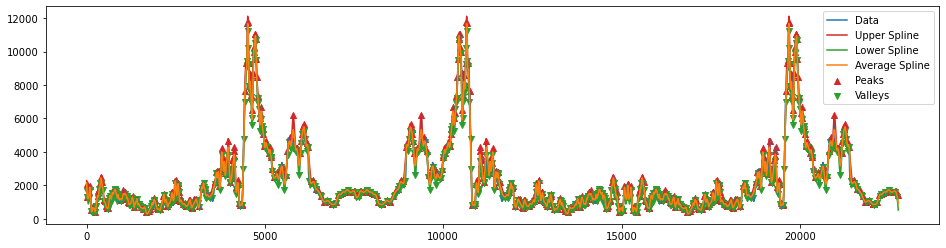

In [10]:
mirror_data = mirror(data)
peak = findpeaks(mirror_data)
valley = findpeaks(-mirror_data)
upper_spline = getspline(mirror_data)
lower_spline = -getspline(-mirror_data)
plt.figure(figsize=(16, 4))
plt.plot(mirror_data, c='tab:blue', label='Data')
plt.scatter(peak, mirror_data[peak], c='tab:red', marker='^', label='Peaks')
plt.scatter(valley, mirror_data[valley], c='tab:green', marker='v', label='Valleys')
plt.plot(upper_spline, c='tab:red', label='Upper Spline')
plt.plot(lower_spline, c='tab:green', label='Lower Spline')
plt.plot((upper_spline + lower_spline) / 2, c='tab:orange', label='Average Spline')
plt.legend()
plt.show()

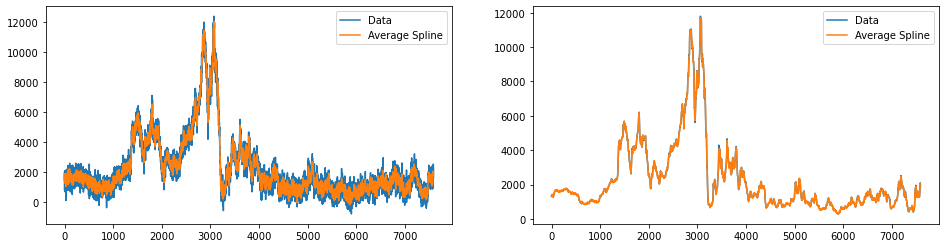

In [11]:
plt.figure(figsize=(16, 4))
noise_data = noise(mirror_data, 400)
upper_spline = getspline(noise_data)
lower_spline = -getspline(-noise_data)
lentgh = len(data)
plt.subplot(1, 2, 1)
plt.plot(noise_data[lentgh-2:-lentgh+2], label='Data')
plt.plot(((upper_spline + lower_spline) / 2)[lentgh-2:-lentgh+2], label='Average Spline')
plt.legend()
for _ in range(99):
    noise_data = noise(mirror_data, 400)
    upper_spline += getspline(noise_data)
    lower_spline += -getspline(-noise_data)
plt.subplot(1, 2, 2)
plt.plot(data, label='Data')
plt.plot(((upper_spline + lower_spline) / 200 )[lentgh-2:-lentgh+2], label='Average Spline')
plt.legend()
plt.show()

<h3>2.2 資料觀察</h3>

    透過觀察與調整，找出適當的分解參數。
    停止分解條件，白噪振幅，總體數量，模態數量

In [12]:
emd_data = emd(d['Actual'])
eemd_data = eemd(d['Actual'], 400, 100, 11)

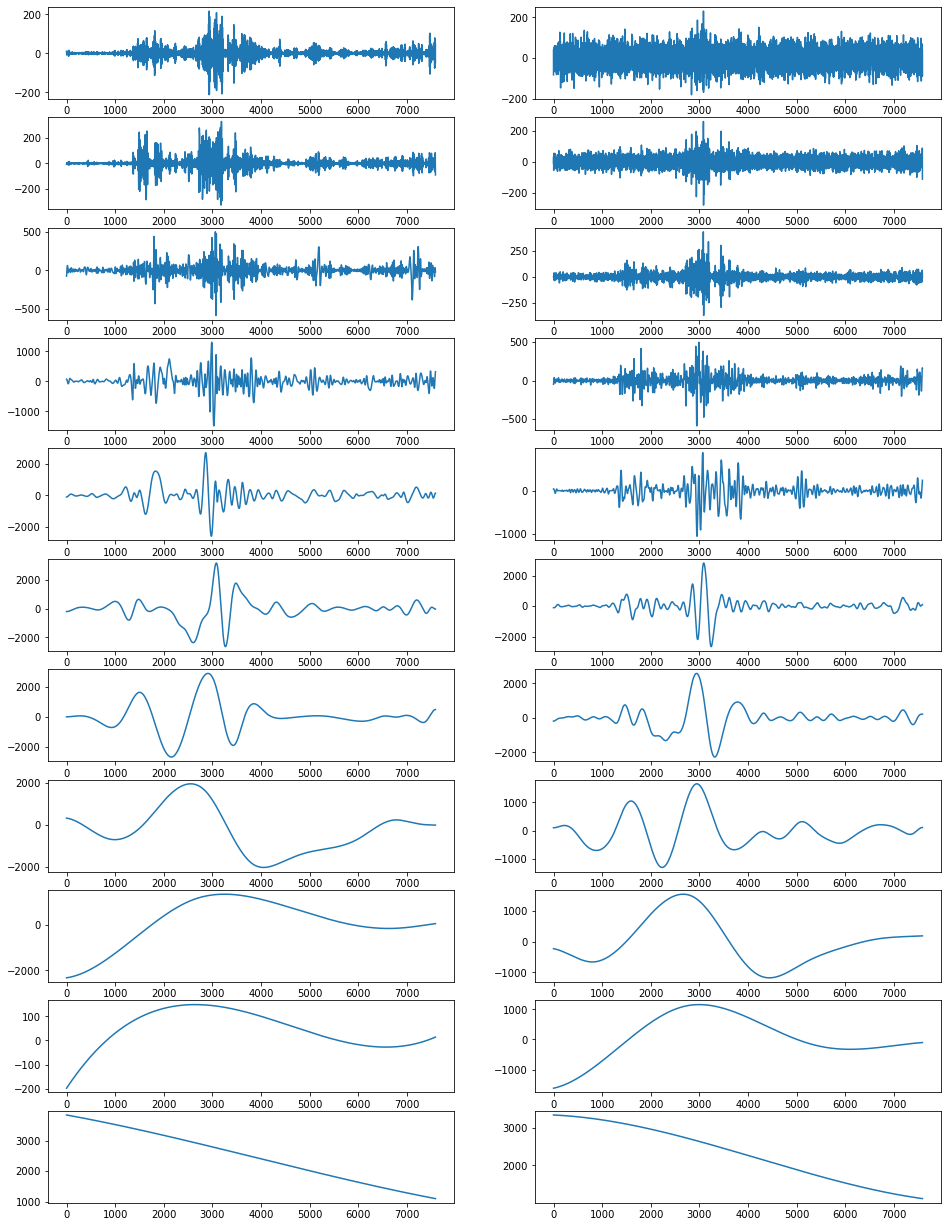

In [13]:
plt.figure(figsize=(16, 22))
for n in range(11):
    plt.subplot(11, 2, 2*(n+1)-1)
    plt.plot(emd_data[n])
    plt.subplot(11, 2, 2*(n+1))
    plt.plot(eemd_data[n])
plt.show()

In [14]:
timesteps = 90
eemd = [np.load(f'EEMD/EEMD{i}.npy').reshape(11, -1, 1) for i in range(1524)]
[i.shape for i in eemd]

[(11, 6065, 1),
 (11, 6066, 1),
 (11, 6067, 1),
 (11, 6068, 1),
 (11, 6069, 1),
 (11, 6070, 1),
 (11, 6071, 1),
 (11, 6072, 1),
 (11, 6073, 1),
 (11, 6074, 1),
 (11, 6075, 1),
 (11, 6076, 1),
 (11, 6077, 1),
 (11, 6078, 1),
 (11, 6079, 1),
 (11, 6080, 1),
 (11, 6081, 1),
 (11, 6082, 1),
 (11, 6083, 1),
 (11, 6084, 1),
 (11, 6085, 1),
 (11, 6086, 1),
 (11, 6087, 1),
 (11, 6088, 1),
 (11, 6089, 1),
 (11, 6090, 1),
 (11, 6091, 1),
 (11, 6092, 1),
 (11, 6093, 1),
 (11, 6094, 1),
 (11, 6095, 1),
 (11, 6096, 1),
 (11, 6097, 1),
 (11, 6098, 1),
 (11, 6099, 1),
 (11, 6100, 1),
 (11, 6101, 1),
 (11, 6102, 1),
 (11, 6103, 1),
 (11, 6104, 1),
 (11, 6105, 1),
 (11, 6106, 1),
 (11, 6107, 1),
 (11, 6108, 1),
 (11, 6109, 1),
 (11, 6110, 1),
 (11, 6111, 1),
 (11, 6112, 1),
 (11, 6113, 1),
 (11, 6114, 1),
 (11, 6115, 1),
 (11, 6116, 1),
 (11, 6117, 1),
 (11, 6118, 1),
 (11, 6119, 1),
 (11, 6120, 1),
 (11, 6121, 1),
 (11, 6122, 1),
 (11, 6123, 1),
 (11, 6124, 1),
 (11, 6125, 1),
 (11, 6126, 1),
 (11, 61

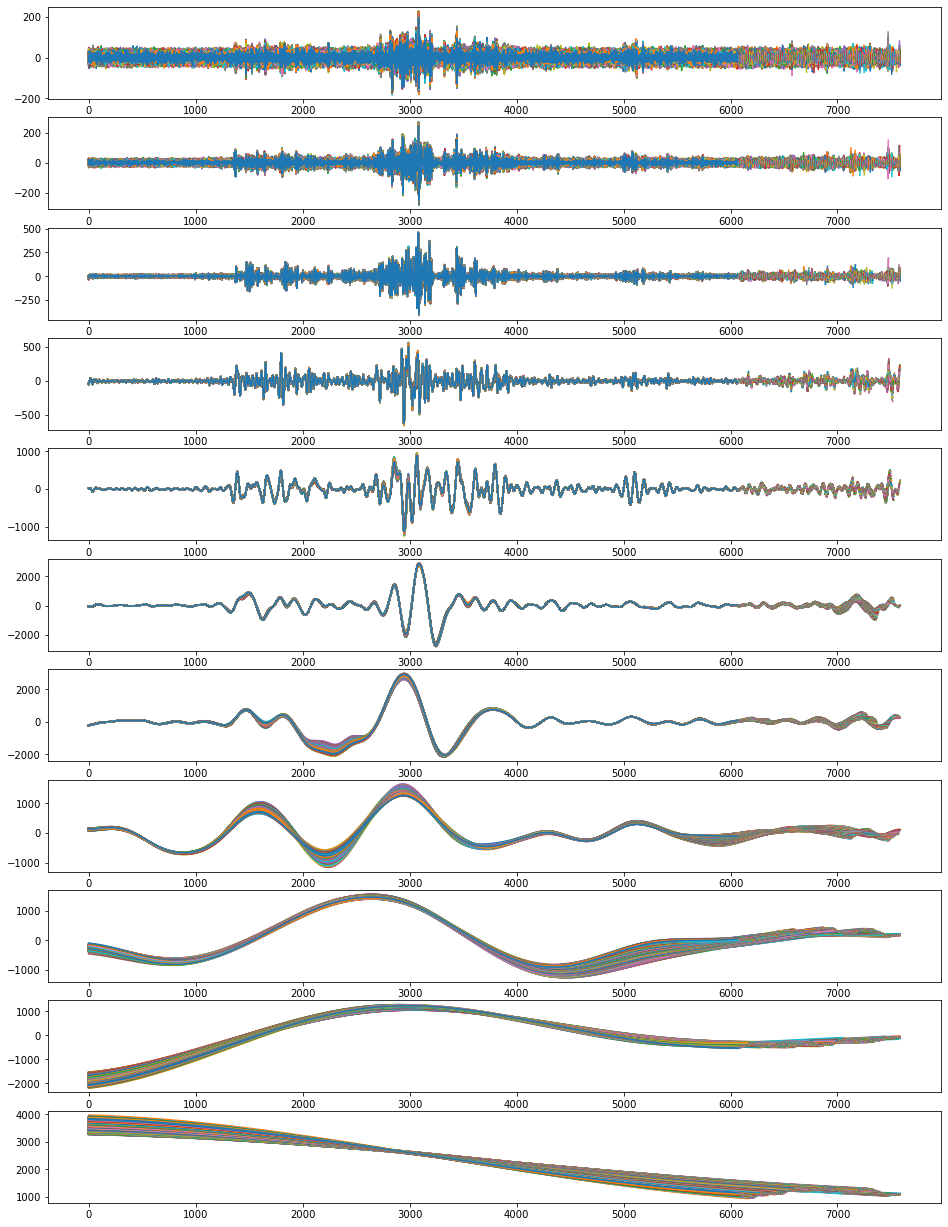

In [15]:
plt.figure(figsize=(16, 22))
for n in range(11):
    plt.subplot(11, 1, n+1)
    for i in eemd[::-2]:
        plt.plot(i[n])
    plt.plot(eemd[0][n], c='tab:blue')
plt.show()

<h3>3.1 建立模型</h3>

    使用多組不同的超參數，針對不同尺度的模態對模型進行訓練。
    訓練集、驗證集、測試集，分別使用獨立的分解數據，以杜絕資料洩漏。

In [16]:
class StandardScaler:
    def __init__(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return data * self.std + self.mean

In [17]:
def create_matrixs(mode, eemd, timesteps):
    x_train, y_train = [], []
    for i in range(timesteps, eemd[23][mode].shape[0]):
        x_train.append(eemd[23][mode, i - timesteps:i])
        y_train.append(eemd[23][mode, i])
    x_test, y_test = [], []
    for i in range(23, 1523):
        x_test.append(eemd[i][mode, -timesteps:])
        y_test.append(eemd[i + 1][mode, -1])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [18]:
def split(x_train, y_train, x_test, y_test, seed=42):
    a = np.arange(x_train.shape[0])
    np.random.seed(seed)
    np.random.shuffle(a)
    b = int(x_test.shape[0] * 0.5)
    return x_train[a], y_train[a], x_test[:b], y_test[:b], x_test[b:], y_test[b:]

In [19]:
def create_model0(shape):
    inputs = Input(shape=(shape[1], shape[2]))
    outputs = Bidirectional(GRU(32, return_sequences=True))(inputs)
    outputs = Bidirectional(GRU(32))(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(16, kernel_initializer='he_uniform', kernel_regularizer=l1())(outputs)
    outputs = LeakyReLU(0.1)(outputs)
    outputs = Dense(1, kernel_regularizer=l2())(outputs)
    return Model(inputs=inputs, outputs=outputs)

In [20]:
def create_model1(shape):
    inputs = Input(shape=(shape[1], shape[2]))
    outputs = Bidirectional(GRU(128, return_sequences=True))(inputs)
    outputs = Bidirectional(GRU(128))(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(64, kernel_initializer='he_uniform')(outputs)
    outputs = LeakyReLU(0.1)(outputs)
    outputs = Dense(1, kernel_regularizer=l2())(outputs)
    return Model(inputs=inputs, outputs=outputs)

In [21]:
def create_model2(shape):
    inputs = Input(shape=(shape[1], shape[2]))
    outputs = Bidirectional(GRU(128, return_sequences=True))(inputs)
    outputs = Bidirectional(GRU(128))(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(64)(outputs)
    outputs = Dense(1, kernel_regularizer=l2())(outputs)
    return Model(inputs=inputs, outputs=outputs)

<h3>3.2 開始訓練</h3>

In [36]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 413,569
Trainable params: 413,569
Non-trainable params: 0
_______________________________________________________

Epoch 24/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0022
Epoch 25/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 26/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0022
Epoch 27/50
12/12 - 1s - loss: 0.0048 - val_loss: 0.0021
Epoch 28/50
12/12 - 1s - loss: 0.0048 - val_loss: 0.0021
Epoch 29/50
12/12 - 1s - loss: 0.0048 - val_loss: 0.0021
Epoch 30/50
12/12 - 1s - loss: 0.0050 - val_loss: 0.0021
Epoch 31/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 32/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 33/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 34/50
12/12 - 1s - loss: 0.0048 - val_loss: 0.0021
Epoch 35/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 36/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 37/50
12/12 - 1s - loss: 0.0049 - val_loss: 0.0021
Epoch 38/50
12/12 - 1s - loss: 0.0048 - val_loss: 0.0021
Epoch 39/50
12/12 - 1s - loss: 0.0050 - val_loss: 0.0022
Epoch 40/50
12/12 - 1s - loss: 0.0048 - val_loss: 0.0021
Epoch 41/50
12/12 - 1s - loss: 

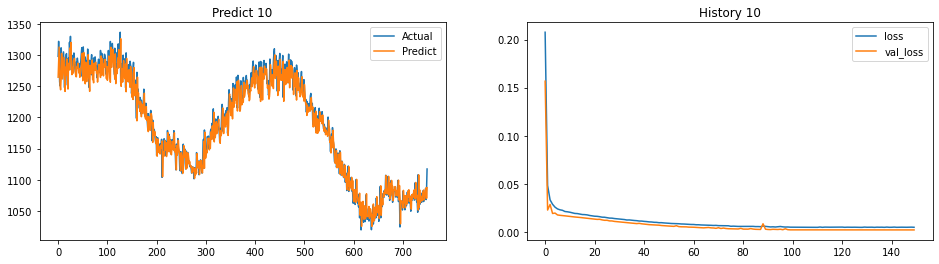

In [23]:

mode = 10
x_train, y_train, x_test, y_test = create_matrixs(mode, eemd, timesteps)
x_train, y_train, x_val, y_val, x_test, y_test = split(x_train, y_train, x_test, y_test)
scaler = StandardScaler(y_train)
d[f'mean{mode}'] = scaler.mean
d[f'std{mode}'] = scaler.std
y_train = scaler.transform(y_train)
x_train = scaler.transform(x_train)
y_val = scaler.transform(y_val)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
model = create_model2(x_train.shape)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
filepath = f'{mode}.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
history0 = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data=(x_val, y_val), 
                     callbacks=[checkpoint], shuffle=True, verbose=2)
model = load_model(filepath)
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.001, momentum=0.9))
history1 = model.fit(x_train, y_train, batch_size=512, epochs=50, validation_data=(x_val, y_val), 
                     callbacks=[checkpoint], shuffle=True, verbose=2)
model = load_model(filepath)
model.evaluate(x_val, y_val, verbose=2)
d[f'x_test{mode}'] = x_test
d[f'Predict{mode}'] = scaler.inverse_transform(model.predict(x_test))
d[f'Actual{mode}'] = y_test
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(d[f'Actual{mode}'], label='Actual')
plt.plot(d[f'Predict{mode}'], label='Predict')
plt.title(f'Predict {mode}')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history0.history['loss'] + history1.history['loss'], label='loss')
plt.plot(history0.history['val_loss'] + history1.history['val_loss'], label='val_loss')
plt.title(f'History {mode}')
plt.legend()
plt.show()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65  

Epoch 21/50
12/12 - 1s - loss: 0.0083 - val_loss: 0.0038
Epoch 22/50
12/12 - 1s - loss: 0.0086 - val_loss: 0.0037
Epoch 23/50
12/12 - 1s - loss: 0.0091 - val_loss: 0.0038
Epoch 24/50
12/12 - 1s - loss: 0.0086 - val_loss: 0.0037
Epoch 25/50
12/12 - 1s - loss: 0.0092 - val_loss: 0.0037
Epoch 26/50
12/12 - 1s - loss: 0.0086 - val_loss: 0.0038
Epoch 27/50
12/12 - 1s - loss: 0.0081 - val_loss: 0.0038
Epoch 28/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0037
Epoch 29/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0037
Epoch 30/50
12/12 - 1s - loss: 0.0085 - val_loss: 0.0037
Epoch 31/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0037
Epoch 32/50
12/12 - 1s - loss: 0.0080 - val_loss: 0.0037
Epoch 33/50
12/12 - 1s - loss: 0.0079 - val_loss: 0.0037
Epoch 34/50
12/12 - 1s - loss: 0.0091 - val_loss: 0.0037
Epoch 35/50
12/12 - 1s - loss: 0.0085 - val_loss: 0.0037
Epoch 36/50
12/12 - 1s - loss: 0.0079 - val_loss: 0.0037
Epoch 37/50
12/12 - 1s - loss: 0.0080 - val_loss: 0.0037
Epoch 38/50
12/12 - 1s - loss: 

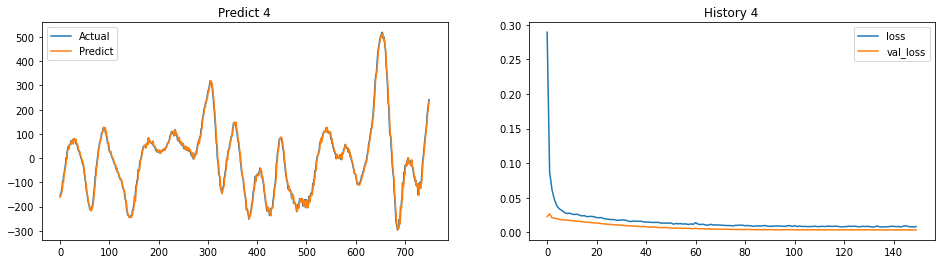

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65  

Epoch 21/50
12/12 - 1s - loss: 0.0082 - val_loss: 0.0021
Epoch 22/50
12/12 - 1s - loss: 0.0091 - val_loss: 0.0021
Epoch 23/50
12/12 - 1s - loss: 0.0081 - val_loss: 0.0021
Epoch 24/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0021
Epoch 25/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0021
Epoch 26/50
12/12 - 1s - loss: 0.0082 - val_loss: 0.0021
Epoch 27/50
12/12 - 1s - loss: 0.0089 - val_loss: 0.0021
Epoch 28/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0021
Epoch 29/50
12/12 - 1s - loss: 0.0089 - val_loss: 0.0021
Epoch 30/50
12/12 - 1s - loss: 0.0085 - val_loss: 0.0021
Epoch 31/50
12/12 - 1s - loss: 0.0091 - val_loss: 0.0021
Epoch 32/50
12/12 - 1s - loss: 0.0085 - val_loss: 0.0021
Epoch 33/50
12/12 - 1s - loss: 0.0085 - val_loss: 0.0021
Epoch 34/50
12/12 - 1s - loss: 0.0085 - val_loss: 0.0021
Epoch 35/50
12/12 - 1s - loss: 0.0090 - val_loss: 0.0021
Epoch 36/50
12/12 - 1s - loss: 0.0086 - val_loss: 0.0021
Epoch 37/50
12/12 - 1s - loss: 0.0087 - val_loss: 0.0021
Epoch 38/50
12/12 - 1s - loss: 

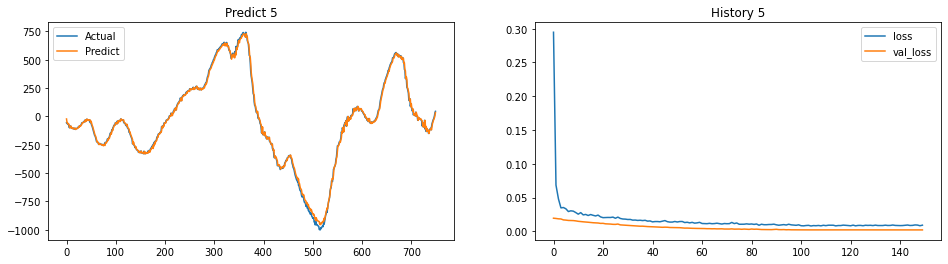

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65  

Epoch 21/50
12/12 - 1s - loss: 0.0072 - val_loss: 0.0014
Epoch 22/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0014
Epoch 23/50
12/12 - 1s - loss: 0.0069 - val_loss: 0.0014
Epoch 24/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0014
Epoch 25/50
12/12 - 1s - loss: 0.0065 - val_loss: 0.0014
Epoch 26/50
12/12 - 1s - loss: 0.0066 - val_loss: 0.0014
Epoch 27/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0014
Epoch 28/50
12/12 - 1s - loss: 0.0066 - val_loss: 0.0014
Epoch 29/50
12/12 - 1s - loss: 0.0071 - val_loss: 0.0014
Epoch 30/50
12/12 - 1s - loss: 0.0066 - val_loss: 0.0014
Epoch 31/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0014
Epoch 32/50
12/12 - 1s - loss: 0.0066 - val_loss: 0.0014
Epoch 33/50
12/12 - 1s - loss: 0.0069 - val_loss: 0.0014
Epoch 34/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0014
Epoch 35/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0014
Epoch 36/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0014
Epoch 37/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0014
Epoch 38/50
12/12 - 1s - loss: 

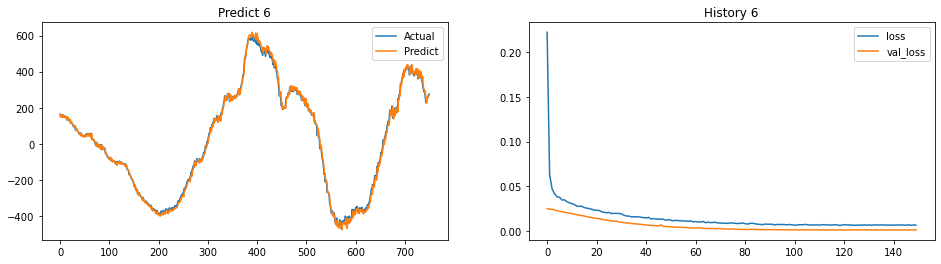

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65  

Epoch 21/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0017
Epoch 22/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0017
Epoch 23/50
12/12 - 1s - loss: 0.0071 - val_loss: 0.0017
Epoch 24/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0017
Epoch 25/50
12/12 - 1s - loss: 0.0067 - val_loss: 0.0017
Epoch 26/50
12/12 - 1s - loss: 0.0071 - val_loss: 0.0017
Epoch 27/50
12/12 - 1s - loss: 0.0067 - val_loss: 0.0017
Epoch 28/50
12/12 - 1s - loss: 0.0072 - val_loss: 0.0017
Epoch 29/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0017
Epoch 30/50
12/12 - 1s - loss: 0.0069 - val_loss: 0.0017
Epoch 31/50
12/12 - 1s - loss: 0.0066 - val_loss: 0.0017
Epoch 32/50
12/12 - 1s - loss: 0.0070 - val_loss: 0.0017
Epoch 33/50
12/12 - 1s - loss: 0.0069 - val_loss: 0.0017
Epoch 34/50
12/12 - 1s - loss: 0.0063 - val_loss: 0.0017
Epoch 35/50
12/12 - 1s - loss: 0.0068 - val_loss: 0.0017
Epoch 36/50
12/12 - 1s - loss: 0.0066 - val_loss: 0.0017
Epoch 37/50
12/12 - 1s - loss: 0.0067 - val_loss: 0.0017
Epoch 38/50
12/12 - 1s - loss: 

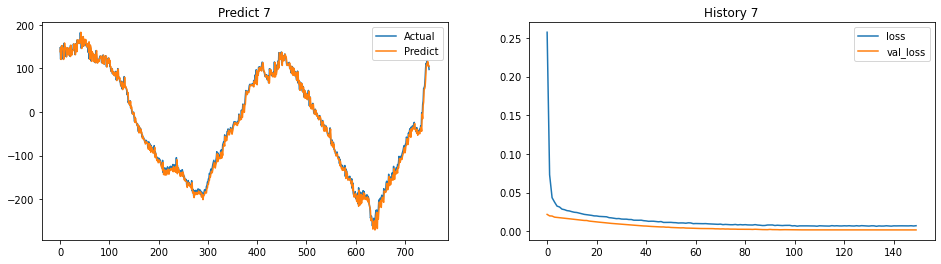

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               296448    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65  

Epoch 21/50
12/12 - 1s - loss: 0.0061 - val_loss: 0.0036
Epoch 22/50
12/12 - 1s - loss: 0.0060 - val_loss: 0.0036
Epoch 23/50
12/12 - 1s - loss: 0.0060 - val_loss: 0.0036
Epoch 24/50
12/12 - 1s - loss: 0.0062 - val_loss: 0.0036
Epoch 25/50
12/12 - 1s - loss: 0.0061 - val_loss: 0.0036
Epoch 26/50
12/12 - 1s - loss: 0.0062 - val_loss: 0.0037
Epoch 27/50
12/12 - 1s - loss: 0.0061 - val_loss: 0.0037
Epoch 28/50
12/12 - 1s - loss: 0.0061 - val_loss: 0.0036
Epoch 29/50
12/12 - 1s - loss: 0.0062 - val_loss: 0.0036
Epoch 30/50
12/12 - 1s - loss: 0.0063 - val_loss: 0.0036
Epoch 31/50
12/12 - 1s - loss: 0.0060 - val_loss: 0.0036
Epoch 32/50
12/12 - 1s - loss: 0.0062 - val_loss: 0.0035
Epoch 33/50
12/12 - 1s - loss: 0.0063 - val_loss: 0.0036
Epoch 34/50
12/12 - 1s - loss: 0.0061 - val_loss: 0.0036
Epoch 35/50
12/12 - 1s - loss: 0.0063 - val_loss: 0.0036
Epoch 36/50
12/12 - 1s - loss: 0.0062 - val_loss: 0.0036
Epoch 37/50
12/12 - 1s - loss: 0.0060 - val_loss: 0.0036
Epoch 38/50
12/12 - 1s - loss: 

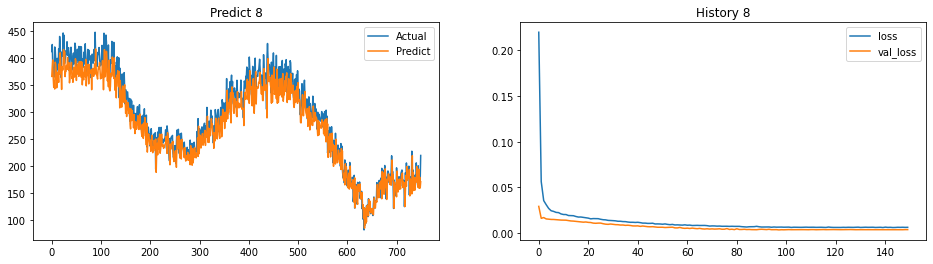

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 90, 256)           100608    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               296448    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65  

Epoch 21/50
12/12 - 1s - loss: 0.0057 - val_loss: 0.0034
Epoch 22/50
12/12 - 1s - loss: 0.0056 - val_loss: 0.0034
Epoch 23/50
12/12 - 1s - loss: 0.0056 - val_loss: 0.0034
Epoch 24/50
12/12 - 1s - loss: 0.0054 - val_loss: 0.0034
Epoch 25/50
12/12 - 1s - loss: 0.0058 - val_loss: 0.0034
Epoch 26/50
12/12 - 1s - loss: 0.0056 - val_loss: 0.0034
Epoch 27/50
12/12 - 1s - loss: 0.0055 - val_loss: 0.0034
Epoch 28/50
12/12 - 1s - loss: 0.0059 - val_loss: 0.0035
Epoch 29/50
12/12 - 1s - loss: 0.0055 - val_loss: 0.0035
Epoch 30/50
12/12 - 1s - loss: 0.0055 - val_loss: 0.0035
Epoch 31/50
12/12 - 1s - loss: 0.0057 - val_loss: 0.0034
Epoch 32/50
12/12 - 1s - loss: 0.0055 - val_loss: 0.0034
Epoch 33/50
12/12 - 1s - loss: 0.0057 - val_loss: 0.0034
Epoch 34/50
12/12 - 1s - loss: 0.0055 - val_loss: 0.0035
Epoch 35/50
12/12 - 1s - loss: 0.0056 - val_loss: 0.0035
Epoch 36/50
12/12 - 1s - loss: 0.0056 - val_loss: 0.0034
Epoch 37/50
12/12 - 1s - loss: 0.0055 - val_loss: 0.0034
Epoch 38/50
12/12 - 1s - loss: 

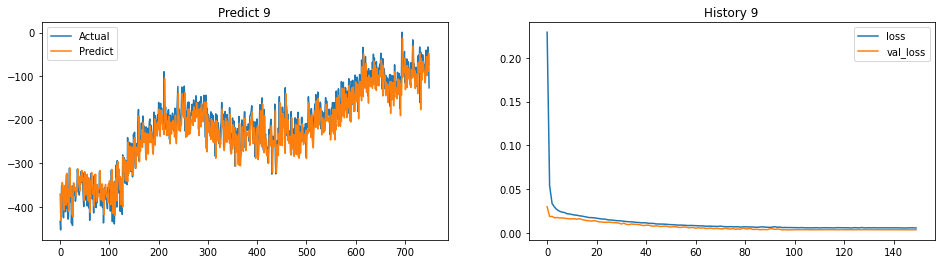

In [24]:
for mode in range(4, 10):
    x_train, y_train, x_test, y_test = create_matrixs(mode, eemd, timesteps)
    x_train, y_train, x_val, y_val, x_test, y_test = split(x_train, y_train, x_test, y_test)
    scaler = StandardScaler(y_train)
    d[f'mean{mode}'] = scaler.mean
    d[f'std{mode}'] = scaler.std
    y_train = scaler.transform(y_train)
    x_train = scaler.transform(x_train)
    y_val = scaler.transform(y_val)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    model = create_model1(x_train.shape)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    filepath = f'{mode}.h5'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
    history0 = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data=(x_val, y_val), 
                         callbacks=[checkpoint], shuffle=True, verbose=2)
    model = load_model(filepath)
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.001, momentum=0.9))
    history1 = model.fit(x_train, y_train, batch_size=512, epochs=50, validation_data=(x_val, y_val), 
                         callbacks=[checkpoint], shuffle=True, verbose=2)
    model = load_model(filepath)
    model.evaluate(x_val, y_val, verbose=2)
    d[f'x_test{mode}'] = x_test
    d[f'Predict{mode}'] = scaler.inverse_transform(model.predict(x_test))
    d[f'Actual{mode}'] = y_test
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(d[f'Actual{mode}'], label='Actual')
    plt.plot(d[f'Predict{mode}'], label='Predict')
    plt.title(f'Predict {mode}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history0.history['loss'] + history1.history['loss'], label='loss')
    plt.plot(history0.history['val_loss'] + history1.history['val_loss'], label='val_loss')
    plt.title(f'History {mode}')
    plt.legend()
    plt.show()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 90, 64)            6720      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                18816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17  

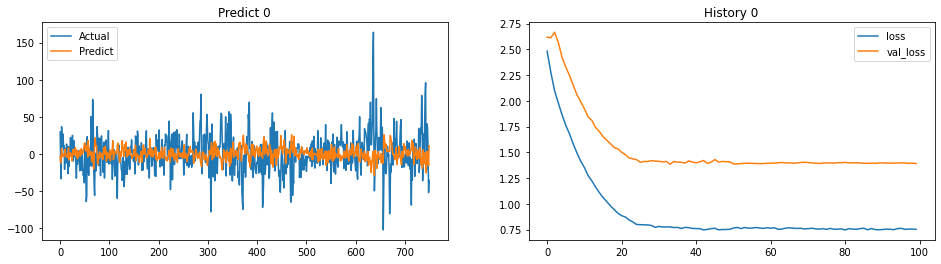

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 90, 64)            6720      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                18816     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17  

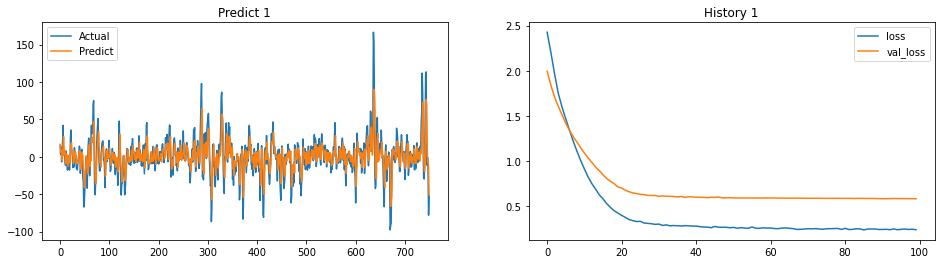

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 90, 64)            6720      
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                18816     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17  

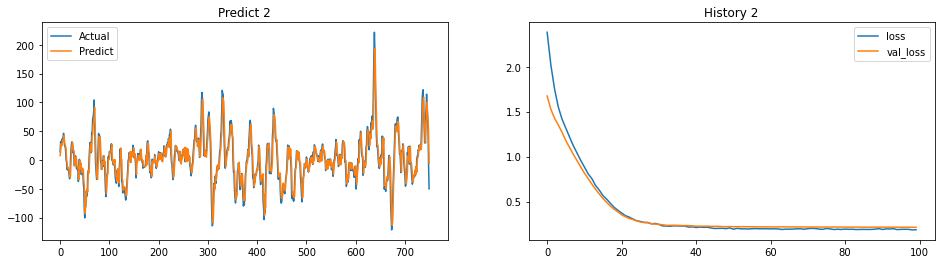

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 90, 1)]           0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 90, 64)            6720      
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 64)                18816     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17 

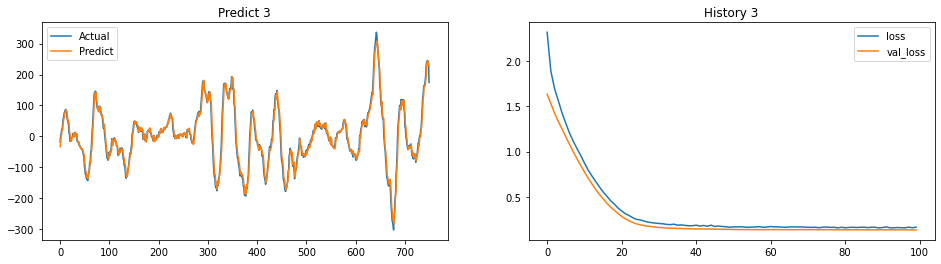

In [25]:
for mode in range(4):
    x_train, y_train, x_test, y_test = create_matrixs(mode, eemd, timesteps)
    x_train, y_train, x_val, y_val, x_test, y_test = split(x_train, y_train, x_test, y_test)
    scaler = StandardScaler(y_train)
    d[f'mean{mode}'] = scaler.mean
    d[f'std{mode}'] = scaler.std
    y_train = scaler.transform(y_train)
    x_train = scaler.transform(x_train)
    y_val = scaler.transform(y_val)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    model = create_model0(x_train.shape)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    filepath = f'{mode}.h5'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
    history0 = model.fit(x_train, y_train, batch_size=512, epochs=50, validation_data=(x_val, y_val), 
                         callbacks=[checkpoint], shuffle=True, verbose=2)
    model = load_model(filepath)
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.001, momentum=0.9))
    history1 = model.fit(x_train, y_train, batch_size=512, epochs=50, validation_data=(x_val, y_val),
                         callbacks=[checkpoint], shuffle=True, verbose=2)
    model = load_model(filepath)
    model.evaluate(x_val, y_val, verbose=2)
    d[f'x_test{mode}'] = x_test
    d[f'Predict{mode}'] = scaler.inverse_transform(model.predict(x_test))
    d[f'Actual{mode}'] = y_test
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(d[f'Actual{mode}'], label='Actual')
    plt.plot(d[f'Predict{mode}'], label='Predict')
    plt.title(f'Predict {mode}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history0.history['loss'] + history1.history['loss'], label='loss')
    plt.plot(history0.history['val_loss'] + history1.history['val_loss'], label='val_loss')
    plt.title(f'History {mode}')
    plt.legend()
    plt.show()

<h3>3.3 單次預測</h3>

    以90天資料，預測下一天的數值。

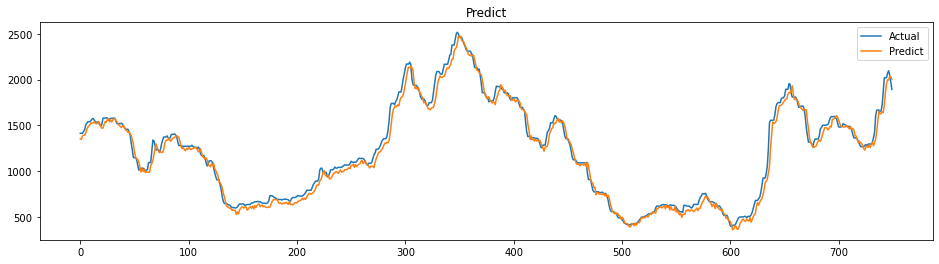

In [26]:
Predict = 0
for i in range(11):
    Predict += d[f'Predict{i}']
d[f'Predict'] = Predict
plt.figure(figsize=(16, 4))
plt.plot(d['Actual'][-Predict.shape[0]:], label='Actual')
plt.plot(Predict, label='Predict')
plt.title('Predict')
plt.legend()
plt.show()

<h3>3.4 連續預測</h3>
    
    以90天資料，預測下一天數值，並將結果作為輸入再進行預測。

In [38]:
def Forecast(data, model):
    a = data.shape[0]
    b = []
    for _ in range(length):
        predict = list(model.predict(data[-a:, 0].reshape(1, -1, 1)).reshape(-1))
        b.append(predict)
        data = np.array(list(data.reshape(-1)) + predict).reshape(-1, 1)
    return np.array(b)

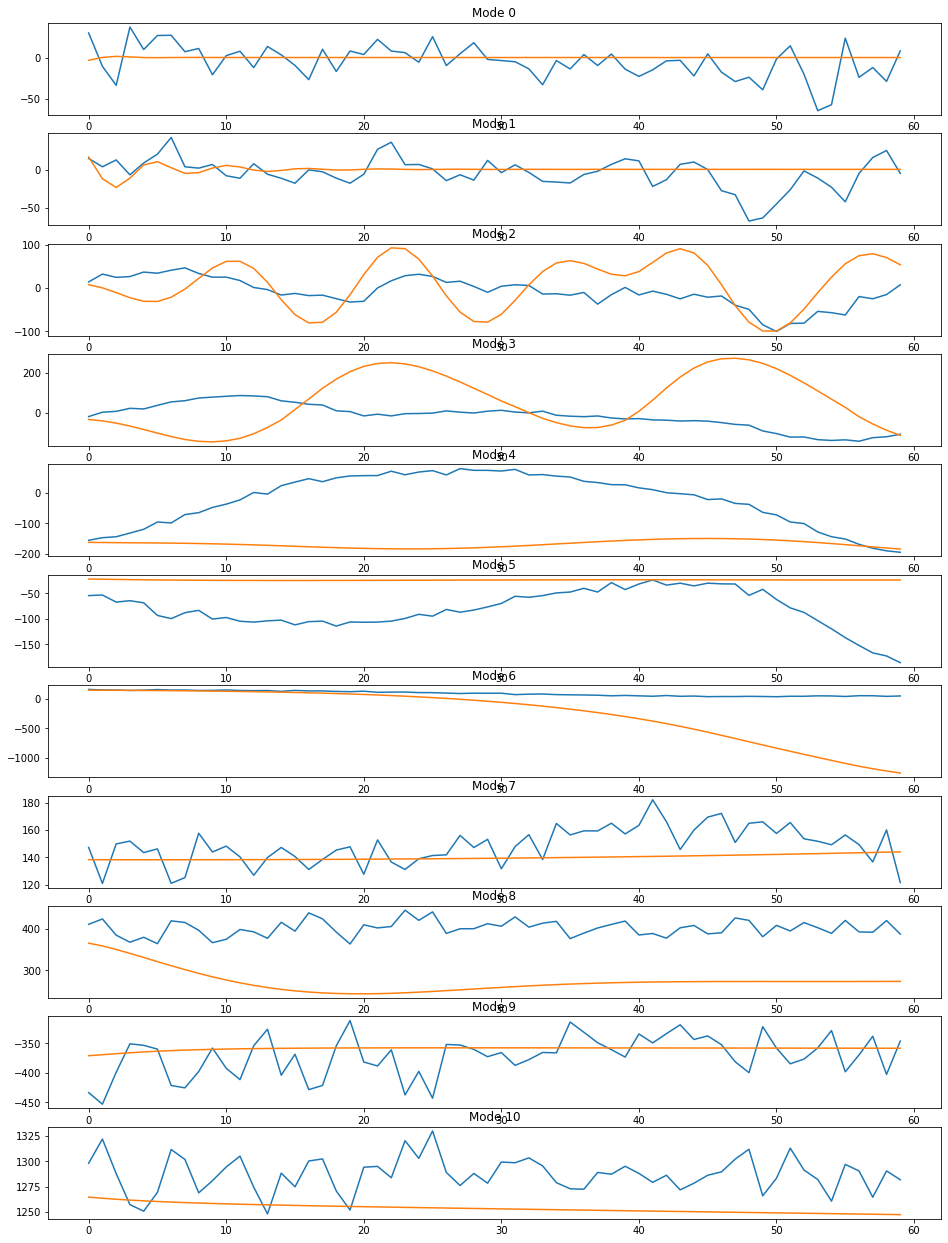

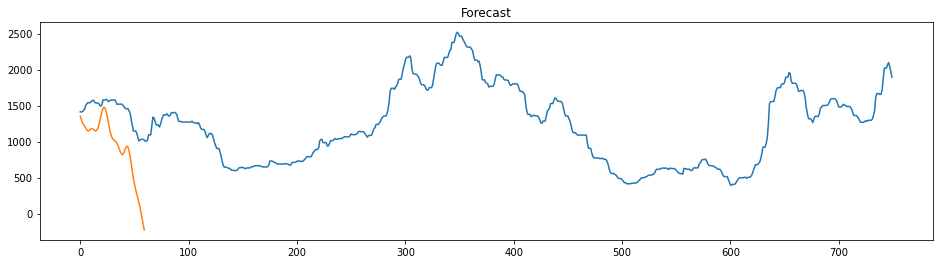

In [40]:
forecast = 0
start = 0
length = 60
plt.figure(figsize=(16, 22))
for mode in range(11):
    filepath = f'{mode}.h5'
    model = load_model(filepath)
    result = Forecast(d[f'x_test{mode}'][start], model) * d[f'std{mode}'] + d[f'mean{mode}']
    plt.subplot(11, 1, mode+1)
    plt.plot(d[f'Actual{mode}'][start:start+60])
    plt.plot(result)
    plt.title(f'Mode {mode}')
    forecast += result
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(d[f'Actual'][-750:])
plt.plot(range(start, start+length),forecast)
plt.title('Forecast')
plt.show()

<h3>4. 總結</h3>

In [29]:
result = pd.DataFrame(columns=['Actual'], data=d['Actual'][-750:])
result['Predict'] = d['Predict']
for i in range(11):
    result[f'Actual{i}'] = d[f'Actual{i}']
    result[f'Predict{i}'] = d[f'Predict{i}']

In [30]:
evaluate = pd.DataFrame(columns=['Total'], data=[(round(np.mean(abs(d[f'Actual'][-750:]-d[f'Predict'].reshape(-1))), 2))])
for i in range(11):
    evaluate[f'Mode{i}'] = [round(np.mean(abs(d[f'Actual{i}']-d[f'Predict{i}'])), 2)]

In [31]:
result.to_csv('BDI_EEMD-LSTM.csv', index=False, header=True)
result

,Actual,Predict,Actual0,Predict0,Actual1,Predict1,Actual2,Predict2,Actual3,Predict3,...,Actual6,Predict6,Actual7,Predict7,Actual8,Predict8,Actual9,Predict9,Actual10,Predict10
0,1413.0,1352.239746,29.671862,-3.300498,14.590753,16.527119,13.865327,7.499531,-18.413368,-32.896660,...,164.690042,151.127136,147.337737,138.387054,411.567873,365.714294,-433.526395,-370.933533,1298.008671,1264.495728
1,1413.0,1347.334106,-10.506141,-12.121601,3.680280,10.479972,31.899884,14.253846,3.460089,-22.525963,...,155.133810,163.721710,121.083717,147.673630,424.513943,384.525421,-453.291641,-415.142090,1321.996656,1289.712402
2,1413.0,1380.557739,-33.373606,-3.558621,12.644650,5.802976,24.375744,28.080114,7.791265,2.543101,...,154.175909,154.024231,149.878471,120.479469,385.249024,395.940491,-399.028643,-431.928101,1287.827300,1312.783569
3,1434.0,1392.489502,36.746924,6.981378,-6.791137,9.633073,26.188261,24.456108,22.953289,6.099246,...,146.947896,153.016907,151.941743,150.297638,368.146874,361.626099,-350.761145,-385.929138,1257.091206,1280.073242
4,1450.0,1391.977295,9.712564,-3.675640,8.665448,-4.870699,36.560972,26.474321,19.746623,23.271526,...,152.480164,145.619873,143.573623,152.416473,380.139764,345.678314,-353.321658,-344.507812,1250.574675,1250.713745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2071.0,1998.745239,40.450728,3.645043,-11.320099,23.218008,89.716405,100.293129,240.062490,239.535736,...,257.510721,243.496124,118.058298,105.860023,162.660179,194.687683,-58.919180,-98.511322,1079.629981,1076.248413
746,2097.0,1995.656738,33.714569,-12.372774,-0.853521,-7.772633,77.884249,78.025810,245.349359,239.290482,...,257.022663,256.952606,113.387954,116.091583,184.910112,159.628143,-74.567894,-73.942947,1086.199341,1081.068115
747,2044.0,2037.644531,6.797522,-1.615569,-18.806117,-4.685214,48.738259,68.880753,232.402168,243.191360,...,266.628336,256.527374,108.806570,111.274956,162.904045,179.997162,-33.118218,-89.363586,1068.343772,1087.135986
748,1970.0,2030.083374,-52.018953,-15.723370,-78.123231,-15.167903,-8.819667,49.093536,230.399109,230.064926,...,267.852471,266.569183,106.821550,106.641441,175.510679,159.860260,-60.232913,-47.207153,1086.554401,1070.401855


In [32]:
evaluate.to_csv('Evaluate.csv', index=False, header=True)
evaluate

,Total,Mode0,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10
0,50.98,20.42,15.02,13.04,12.47,11.35,16.15,14.37,9.06,23.56,33.53,16.09


In [33]:
np.save('BDI_EEMD-LSTM.npy', d) 

In [37]:
d = np.load('BDI_EEMD-LSTM.npy',allow_pickle='TRUE').item()
d.keys()

dict_keys(['Actual', 'mean10', 'std10', 'x_test10', 'Predict10', 'Actual10', 'mean4', 'std4', 'x_test4', 'Predict4', 'Actual4', 'mean5', 'std5', 'x_test5', 'Predict5', 'Actual5', 'mean6', 'std6', 'x_test6', 'Predict6', 'Actual6', 'mean7', 'std7', 'x_test7', 'Predict7', 'Actual7', 'mean8', 'std8', 'x_test8', 'Predict8', 'Actual8', 'mean9', 'std9', 'x_test9', 'Predict9', 'Actual9', 'mean0', 'std0', 'x_test0', 'Predict0', 'Actual0', 'mean1', 'std1', 'x_test1', 'Predict1', 'Actual1', 'mean2', 'std2', 'x_test2', 'Predict2', 'Actual2', 'mean3', 'std3', 'x_test3', 'Predict3', 'Actual3', 'Predict'])